Kaggle Competition: House Prices

Project Team: Jason Harville, Dan Wald, Andrea Pope

## Prep, Data Load and Cleansing

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# general libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from numpy import *
import pickle
import math
import csv
from itertools import izip

# functions to clean data and process data throughout, see external .py file
from data_funcs import *

#sklearn libraries
from sklearn.feature_extraction.text import *
from sklearn.neural_network import *
from sklearn import tree
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_predict
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest

#sklearn regressors
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor 
from sklearn.linear_model import LogisticRegression

#sklearn classifiers
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier

### UN-PICKLE FROM PREVIOUS RUNS

In [10]:
# results from previous runs, used to speed execution at different points through (avoid repeating long steps)
# code used to produce pickle also included throughout
model_results = pickle.load(open( "./model_results.p", "rb" ) )
grid_results = pickle.load(open( "./grid_results.p", "rb" ) )
best_cat_models = pickle.load(open("./best_cat_models.p", "rb"))

## Data Cleansing and Prep

The data available was divided into 3 main types of data:
1. Categorical: divided into dummy variables representing each sub-category
2. Continuous: numerical data
3. Likert scale: ratings converted to numerical scale

After the raw processing of each data type, mean normlization was conducted to ensure no feature had undue weight in comparison to another feature.

Additionally, 5 features were excluded due to insignificant population or information similar to all variables.

## Data Import + Data Wrangling

In [3]:
'''
This code is intentionally commented out but included so that the reviewer understands how our team split the data. 
All development and evaluation has been performed on the split data included with the submission in the 'data' folder.

DO NOT RUN.  If this block of code is executed, it will re-write the new train and dev sets randomly, 
yeilding non-repeatable results

The code below imports the source file, shuffles, splits and exports the data as two seperate .csv files 
located in ./data folder
'''
# # importing original training dataset
# train_original = pd.read_csv('data/train.csv')
# num_examples = len(train_original)

# # shuffling indices
# shuffle = np.random.permutation(np.arange(num_examples))

# # sorting training set by shuffled indices and splitting to training and dev sets
# train_shuffled = train_original.iloc[shuffle]
# train_split = train_shuffled[num_examples/10:]  
# dev_split = train_shuffled[:num_examples/10]

# # saving to csv
# train_split.to_csv('./data/train_split.csv')
# dev_split.to_csv('./data/dev_split.csv')

"\nThis code is intentionally commented out but included so that the reviewer understands how our team split the data. \nAll development and evaluation has been performed on the split data included with the submission in the 'data' folder.\n\nDO NOT RUN.  If this block of code is executed, it will re-write the new train and dev sets randomly, \nyeilding non-repeatable results\n\nThe code below imports the source file, shuffles, splits and exports the data as two seperate .csv files \nlocated in ./data folder\n"

In [4]:
# Read the split data

train = pd.read_csv('./data/train_split.csv')
dev = pd.read_csv('./data/dev_split.csv')

In [5]:
'''
The below code references functions defined in data_funcs.py, included with submission
'''

# Variables for processing 
# Leverages early work to identify variable types that are handled seperately in transform_features function
normal_cat_features = ['MSZoning','LandContour','LotShape','LotConfig','LandSlope','Neighborhood','BldgType','HouseStyle','RoofStyle','MasVnrType',
                       'Foundation','Heating','Electrical','Functional','GarageType','GarageFinish','PavedDrive',
                       'Fence','MiscFeature','SaleType','SaleCondition']

special_cat_features = ['CentralAir','Condition1','Condition2','Exterior1st','Exterior2nd','BsmtFinType1','BsmtFinType2']

used_cat_features = normal_cat_features + special_cat_features

drop_features = ['MSSubClass','Street','Alley','Utilities','RoofMatl']
drop_dummies = ['MSZoning_C (all)','LotShape_Reg','LotShape_IR1','LotShape_IR2','LotShape_IR3','LotConfig_FR2','LotConfig_FR3']

feature_dict = get_train_cat_features(train_data=train, used_cat_features=used_cat_features)

likert_features = ['ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure','HeatingQC','KitchenQual',
                   'FireplaceQu','GarageQual','GarageCond','PoolQC']

# Getting labels and data
train_labels = train['SalePrice']
dev_labels = dev['SalePrice']

# restructure the datasets to keep only variables and not the output
keep_columns = [col for col in train.columns if col not in ['Unnamed: 0', 'SalePrice', 'Id']]
train_data = train.set_index('Id')[keep_columns]
dev_data = dev.set_index('Id')[keep_columns]

#transforming features
train_data = transform_features(train_data,feature_dict,normal_cat_features,used_cat_features,
                                likert_features,drop_dummies,drop_features)
dev_data = transform_features(dev_data,feature_dict,normal_cat_features,used_cat_features,
                              likert_features,drop_dummies,drop_features)

# Mean normalizing
features_to_normalize = train_data.columns
mn_values = {value: find_mu_std(train_data, value) for value in features_to_normalize}

train_data = mean_normalization(train_data, features_to_normalize, mn_values)
final_features = train_data.columns
dev_data = mean_normalization(dev_data, features_to_normalize, mn_values)

In [6]:
# Reshape the data
# convert to np arrays
train_data = np.array(train_data)
dev_data = np.array(dev_data)
type(train_data)

# deal with NaNs (which won't work in regression)
where_are_NaNs = isnan(train_data)
train_data[where_are_NaNs] = 0

where_are_NaNs = isnan(dev_data)
dev_data[where_are_NaNs] = 0


## Execution

Notes:
Univariate feature selection examines each feature individually to determine the strength of the relationship of the feature with the response variable. These methods are simple to run and understand and are in general particularly good for gaining a better understanding of data (but not necessarily for optimizing the feature set for better generalization). There are lot of different options for univariate selection.

## Executing Across Different Categorical Thresholds

Early threshold and parameter tuning.  The below code obtains the best categories.  Since this is only run once, there is no need to encapsulate as a function

The best accuracy in the categorical division does not necessarily drive the best categorization for the final price prediction.
For that reason, we'll take an approach that manually goes through various thresholds for splitting the training data, and
feature pruning, and matching into categories.
We'll run each of those through a separate pipeline (to be optimized) to measure accuracy of the final price prediction. Adjusting parameters in the final model.

In [8]:
'''
this set of code is determining best way to split data into categories
code runs an initial price prediction (to guage success of categories, but this will be enahnced later)

NOTE: thresholds used were based on analysis of the original data, and our original baseline results
The large set of test thresholds requires significant computing. 
We ran overnight and pickled the data for future use to prevent the need to re-process
The current thresholds selected turned out to be the winning set, so a new user will arrive at the same result without 
significant processing.

In addition t thresholds, other components have also been simplified to make processing easier (to prove code runs).
However, the results in the pickle file were against the larger range of components.

For data manipulation, we have pickled the data so that this code does not need to be run at all to arrive at conclusions.
'''
# test_thresholds = [[40000], [80000], [100000],[150000], [200000], [300000], [350000], [400000], [450000],
#                  [40000, 300000], [40000,350000], [40000,400000],[80000, 300000], [80000,350000], [80000,400000]]
# test_thresholds = [[40000,350000]]

# C=[0.1, 0.5, 1, 1.5, 10]
# estimators = [100, 500, 1000, 5000]
# test_components = [5, 10, 15, 20, 25]
test_thresholds = [[350000]]
C=[10]
estimators = [100]
test_components = [10]

model_results = []

# determine how to break the data into categories
for t in test_thresholds:
    print 'Category Thresholds: ', t
    train_cat_labels = list(categorize_prices(labels=train_labels, thresholds = t))
    dev_cat_labels = list(categorize_prices(labels=dev_labels, thresholds = t))
    
    # L1 to build subset of data (without low value features)
    train_subset, dev_subset, nonzero_features = run_logr_l1(train_data, train_cat_labels, dev_data, 
                                                             final_features)
    # further reduction with PCA
    # test withh several different # of components
    for c in test_components:
        if (c < train_subset.shape[1]):
            # check we have that many components
            train_pca_subset, dev_pca_subset = run_pca(train_subset, dev_subset, components = c)
    
            #Place into categories using logistics l2
            for c1 in C:
                train_categories, dev_categories = run_logr_l2(train_pca_subset, train_cat_labels, 
                                                               dev_pca_subset, c=c1)
        
                #run Linear Regression on each class defined and calculate overall accuracy
                result = run_lr(train_categories, dev_categories, train_pca_subset, train_labels, dev_pca_subset, dev_labels)
                model_results.append([t, c, "logr", c1, "lr", "", result])
        
                for e in estimators:
                    result = run_rfr(train_categories, dev_categories, train_data, train_labels, dev_data, 
                                     dev_labels, estimators = e)
                    model_results.append([t, c, "logr", c1, "rfr", e, result])

            # Place into categories using Random Forrest Classifier
            for e in estimators:
                train_categories, dev_categories = run_rfc(train_pca_subset, train_cat_labels, 
                                                           dev_pca_subset, estimators=e)
        
                #run Linear Regression on each class defined and calculate overall accuracy
                result = run_lr(train_categories, dev_categories, train_pca_subset, train_labels, dev_pca_subset, dev_labels)
                model_results.append([t, c, "rfc", e, "lr", "", result])
        
                for e2 in estimators:
                    result = run_rfr(train_categories, dev_categories, train_data, train_labels, dev_data, 
                                     dev_labels, estimators = e2)
                    model_results.append([t, c, "rfc", e, "rfr", e2, result])

            # Place into categories using adaboost decision tree
            for e in estimators:
                for lrn_rate in (0.1, 1):
                #for lrn_rate in (0.1, 0.5, 1, 1.5):
                    train_categories, dev_categories = run_abc(train_pca_subset, train_cat_labels, 
                                                               dev_pca_subset,
                                                               estimators=e, lrn_rate=lrn_rate)
                        
                    #run Linear Regression on each class defined and calculate overall accuracy
                    abc_desc = str(e) + ", " +  str(lrn_rate) 
                    result = run_lr(train_categories, dev_categories, train_pca_subset, train_labels, dev_pca_subset, dev_labels)
                        
                    model_results.append([t, c, "adc", abc_desc, "lr", "", result])
        
                for e2 in estimators:
                    result = run_rfr(train_categories, dev_categories, train_data, train_labels, dev_data, 
                                     dev_labels, estimators = e2)
                    model_results.append([t, c, "abc", abc_desc, "rfr", e2, result])
  

Category Thresholds:  [350000]


## The best Categorization breakdown and model to date

Best ever result(stoichastic):
[[40000, 300000, 'logr', 0.1441778680151591]]

**Note** 
If you run the code above, if you want to see results, similar to our team results (run on the larger data set),
you can reload the pickle files.

In [11]:
# top 3 classifier model results
model_results_sorted = sorted(model_results, key=lambda x: x[6])
top_3_models = model_results_sorted[0:3]
best_model = model_results_sorted[0]
print 'top three models \n', top_3_models

top three models 
[[[40000, 350000], 10, 'logr', 10, 'lr', '', 0.15368958570482674], [[40000, 350000], 25, 'logr', 1, 'lr', '', 0.15462395642721133], [[40000, 350000], 15, 'adc', '500, 3, 0.1', 'lr', '', 0.15523693930362142]]


with best results, rerun to break into categories based on threshold, method, and parameter indicatec
possibly could run for top 3 best results (or top n)

With the data separated into categories, we'll enhance the price prediction

In [12]:
'''
this is to determine best price predictin model per categry
the best model for each category then separated to be run against test data
split into categories as thresholds defined as best
'''
#redefine variables
t = best_model[0] #threshold
c = best_model[1] #PCA components
c1 = best_model[3] #L2 regularization
grid_results = []

train_cat_labels = list(categorize_prices(labels=train_labels, thresholds = t))
dev_cat_labels = list(categorize_prices(labels=dev_labels, thresholds = t))

#use best method and parameters (above) to divide into categories
#L1
train_subset, dev_subset, nonzero_features = run_logr_l1(train_data, train_cat_labels, dev_data, final_features)
#PCA with components = 
train_pca_subset, dev_pca_subset = run_pca(train_subset, dev_subset, components = c)
#categorize (assume logR for now, could change)
train_categories, dev_categories = run_logr_l2(train_pca_subset, train_cat_labels, dev_pca_subset, c=c1)

# Regression
The following blocks of code run various forms of regression on each category of data, and store the results for later analysis.
In each case, we are running a grid search to optimize model parameters.

### LINEAR REGRESSION

In [13]:
#build subsets of training and dev based on categories
for cat in list(unique(train_categories)):
    #print(cat)
    #get index of train and dev obs in this category, and separate data
    idx = list(np.array(np.where(train_categories == cat))[0])
    idx_dev = list(np.array(np.where(dev_categories == cat))[0])
    train = train_data.take(idx, axis=0) # axis = 0 provides the reduced components for positive
    trn_labels = train_labels.take(idx, axis=0) 
    dev = dev_data.take(idx_dev, axis=0)  
    dv_labels = dev_labels.take(idx_dev, axis=0)
    
    #for each category, run a gridsearch to determine optimal parameters for price prediction for category
    pca = PCA(n_components=2) # PCA to remove demensionality and colinearity
    selection = SelectKBest(k=1) # Select some original features where appropriate
    combined_features = FeatureUnion([("pca", pca), ("univ_select", selection)]) # Build estimator from PCA and Univariate selection:
    features = combined_features.fit(train, trn_labels).transform(train) # Use combined features to transform dataset:
    
    #LR Regression
    lr = LinearRegression(fit_intercept=True, n_jobs=-1)

    # Do grid search over k, n_components and C:

    pipeline = Pipeline([("features", combined_features), ("lr", lr)])

    param_grid = dict(features__pca__n_components=[10, 15, 20, 25, 30],
                      features__univ_select__k=[5, 10, 15, 20],
                      lr__fit_intercept=[True, False])

    grid_search = GridSearchCV(pipeline, param_grid=param_grid, refit=True)
    grid_search.fit(train, trn_labels)
    
    # summarize the results of the grid search
    print(grid_search.best_estimator_)
    print(grid_search.best_score_)
    print(grid_search.best_params_)

    grid_results.append([cat,'lr',grid_search]) # append into an array for post-processing

C:\Users\andre\Anaconda2\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [ 96 105 113 125 133 137 142 154 187] are constant.
  UserWarning)
C:\Users\andre\Anaconda2\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw
C:\Users\andre\Anaconda2\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\andre\Anaconda2\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [ 96 103 107 113 120 125 133 137 142 148 154 159 167 187] are constant.
  UserWarning)
C:\Users\andre\Anaconda2\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [ 96 103 105 108 109 113 115 125 133 137 142 154 183 187] are constant.
  UserWarning)
C:\Users\andre\Anaconda2\lib\site-packages\sklearn\feature_selecti

Pipeline(steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('pca', PCA(copy=True, iterated_power='auto', n_components=30, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('univ_select', SelectKBest(k=20, score_func=<function f_classif at 0x000000000BBC1F98>))],
       transformer_weights=None)), ('lr', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False))])
0.879443781914
{'features__pca__n_components': 30, 'lr__fit_intercept': True, 'features__univ_select__k': 20}


C:\Users\andre\Anaconda2\lib\site-packages\sklearn\feature_selection\univariate_selection.py:109: RuntimeWarning: invalid value encountered in divide
  msw = sswn / float(dfwn)


Pipeline(steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('pca', PCA(copy=True, iterated_power='auto', n_components=15, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('univ_select', SelectKBest(k=10, score_func=<function f_classif at 0x000000000BBC1F98>))],
       transformer_weights=None)), ('lr', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False))])
-0.310546736131
{'features__pca__n_components': 15, 'lr__fit_intercept': True, 'features__univ_select__k': 10}


### RANDOM FOREST REGRESSION

In [14]:
#build subsets of training and dev based on categories
for cat in list(unique(train_categories)):
    #get index of train and dev obs in this category, and separate data
    idx = list(np.array(np.where(train_categories == cat))[0])
    idx_dev = list(np.array(np.where(dev_categories == cat))[0])
    train = train_data.take(idx, axis=0) # axis = 0 provides the reduced components for positive
    trn_labels = train_labels.take(idx, axis=0) 
    dev = dev_data.take(idx_dev, axis=0)  
    dv_labels = dev_labels.take(idx_dev, axis=0)
    
    #for each category, run a gridsearch to determine optimal parameters for price prediction for category
    pca = PCA(n_components=2) # PCA to remove demensionality and colinearity
    selection = SelectKBest(k=1) # Select some original features where appropriate
    combined_features = FeatureUnion([("pca", pca), ("univ_select", selection)]) # Build estimator from PCA and Univariate selection:
    features = combined_features.fit(train, trn_labels).transform(train) # Use combined features to transform dataset:
    
    #Random Forest Regression
    rfr = RandomForestRegressor(n_estimators=100, random_state=0, n_jobs=-1)

    # Do grid search over k, n_components and # of estimators
    pipeline = Pipeline([("features", combined_features), ("rfr", rfr)])
    param_grid = dict(features__pca__n_components=[10, 15, 20, 25, 30],
                      features__univ_select__k=[5, 10, 15, 20],
                      rfr__n_estimators=[100, 200, 500, 1000])
    grid_search = GridSearchCV(pipeline, param_grid=param_grid, refit=True)
    grid_search.fit(train, trn_labels)
    
    # summarize the results of the grid search
    print(grid_search.best_estimator_)
    print(grid_search.best_score_)
    print(grid_search.best_params_)
    
    grid_results.append([cat,'rfr',grid_search]) # append into an array for post-processing

Pipeline(steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('pca', PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('univ_select', SelectKBest(k=20, score_func=<function f_classif at 0x000000000BBC1F98>))],
       trans...timators=1000, n_jobs=-1, oob_score=False, random_state=0,
           verbose=0, warm_start=False))])
0.866877409008
{'features__pca__n_components': 10, 'rfr__n_estimators': 1000, 'features__univ_select__k': 20}
Pipeline(steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('pca', PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('univ_select', SelectKBest(k=20, score_func=<function f_classif at 0x000000000BBC1F98>))],
       trans...stimators=100, n_jobs=-1, oob_score=False, random_state=0,
           verbose=0, warm_start=False))])
-0.361159855131
{'features__pca__n_components': 10, 'rfr__n_es

### KNN REGRESSION

In [15]:
for cat in list(unique(train_categories)):
    #get index of train and dev obs in this category, and separate data
    idx = list(np.array(np.where(train_categories == cat))[0])
    idx_dev = list(np.array(np.where(dev_categories == cat))[0])
    train = train_data.take(idx, axis=0) # axis = 0 provides the reduced components for positive
    trn_labels = train_labels.take(idx, axis=0) 
    dev = dev_data.take(idx_dev, axis=0)  
    dv_labels = dev_labels.take(idx_dev, axis=0)
    
    #for each category, run a gridsearch to determine optimal parameters for price prediction for category
    pca = PCA(n_components=2) # PCA to remove demensionality and colinearity
    selection = SelectKBest(k=1) # Select some original features where appropriate
    combined_features = FeatureUnion([("pca", pca), ("univ_select", selection)]) # Build estimator from PCA and Univariate selection:
    features = combined_features.fit(train, trn_labels).transform(train) # Use combined features to transform dataset:
    
    #KNN Regressor
    knn = KNeighborsRegressor(n_neighbors=10, weights='uniform',n_jobs=-1, algorithm='auto')
    pipeline = Pipeline([("features", combined_features), ("knn", knn)])
    param_grid = dict(features__pca__n_components=[2, 4, 6, 8, 10],
                      #features__univ_select__k=[5, 10, 15, 20],
                      knn__n_neighbors=[2, 4, 6, 8, 10],
                      knn__weights=['uniform', 'distance'],
                      knn__p=[1,2])
    grid_search = GridSearchCV(pipeline, param_grid=param_grid, refit=True)
    grid_search.fit(train, trn_labels)

    # summarize the results of the grid search
    print(grid_search.best_estimator_)
    print(grid_search.best_score_)
    print(grid_search.best_params_)
    
    grid_results.append([cat,'knn',grid_search]) # append into an array for post-processing

Pipeline(steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('pca', PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('univ_select', SelectKBest(k=1, score_func=<function f_classif at 0x000000000BBC1F98>))],
       transformer_weights=None)), ('knn', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=8, p=2,
          weights='distance'))])
0.812175086608
{'features__pca__n_components': 10, 'knn__weights': 'distance', 'knn__n_neighbors': 8, 'knn__p': 2}
Pipeline(steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('pca', PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('univ_select', SelectKBest(k=1, score_func=<function f_classif at 0x000000000BBC1F98>))],
       transformer_weights=None)), ('knn', KNeighborsRegressor(algorithm='auto', leaf

### MULTIPLE LINEAR PERCEPTRON REGRESSION (NEURAL NET)

In [16]:
for cat in list(unique(train_categories)):
    #get index of train and dev obs in this category, and separate data
    idx = list(np.array(np.where(train_categories == cat))[0])
    #idx_dev = list(np.array(np.where(dev_categories == cat))[0])
    train = train_data.take(idx, axis=0) # axis = 0 provides the reduced components for positive
    trn_labels = train_labels.take(idx, axis=0) 
    #dev = dev_data.take(idx_dev, axis=0)  
    #dv_labels = dev_labels.take(idx_dev, axis=0)
    
    mlp = MLPRegressor(alpha = 0.001, solver='lbfgs', learning_rate = 'constant')
    
    # Do grid search
    pipeline = Pipeline([("mlp", mlp)])
    param_grid = dict(mlp__alpha = [0.0001, 0.001, .01, .1], 
                      mlp__learning_rate = ['constant', 'invscaling', 'adaptive'] )
    grid_search = GridSearchCV(pipeline, param_grid=param_grid, refit=True)
    grid_search.fit(train, trn_labels)

    # summarize the results of the grid search
    print(grid_search.best_estimator_)
    print(grid_search.best_score_)
    print(grid_search.best_params_)
    
    grid_results.append([cat,'mlp',grid_search]) # append into an array for post-processing

Pipeline(steps=[('mlp', MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='lbfgs', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False))])
0.846379913328
{'mlp__learning_rate': 'adaptive', 'mlp__alpha': 0.0001}
Pipeline(steps=[('mlp', MLPRegressor(activation='relu', alpha=0.1, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='lbfgs', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False))])
-0.735828

### AdaBoost REGRESSION

In [18]:
# AdaBoost Regression
for cat in list(unique(train_categories)):
    #get index of train and dev obs in this category, and separate data
    idx = list(np.array(np.where(train_categories == cat))[0])
    train = train_data.take(idx, axis=0) # axis = 0 provides the reduced components for positive
    trn_labels = train_labels.take(idx, axis=0) 
    
    #for each category, run a gridsearch to determine optimal parameters for price prediction for category
    pca = PCA(n_components=2) # PCA to remove demensionality and colinearity
    selection = SelectKBest(k=1) # Select some original features where appropriate
    combined_features = FeatureUnion([("pca", pca), ("univ_select", selection)]) # Build estimator from PCA and Univariate selection:
    features = combined_features.fit(train, trn_labels).transform(train) # Use combined features to transform dataset:
    
    #adaboost Regression
    adr = AdaBoostRegressor(base_estimator=None, n_estimators=50, learning_rate=1.0, loss='linear')
    #There is a trade-off between learning_rate and n_estimators
    
    pipeline = Pipeline([("features", combined_features), ("adr", adr)])
    param_grid = dict(features__pca__n_components=[10, 15, 20, 25, 30],
                      features__univ_select__k=[5, 10, 15, 20],
                      adr__n_estimators=[50, 100],
                      adr__learning_rate=[.1, .5],
                      adr__loss=['linear', 'square', 'exponential'])
                      
    # subset for rerun
    # adr__n_estimators=[50, 100, 150, 200, 500, 1000]  
    # adr__learning_rate=[.1, .5, 1, 1.5, 3]
    grid_search = GridSearchCV(pipeline, param_grid=param_grid, refit=True)
    grid_search.fit(train, trn_labels)

    # summarize the results of the grid search
    print(grid_search.best_estimator_)
    print(grid_search.best_score_)
    print(grid_search.best_params_)
    
    grid_results.append([cat,'adb',grid_search]) # append into an array for post-processing

Pipeline(steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('pca', PCA(copy=True, iterated_power='auto', n_components=30, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('univ_select', SelectKBest(k=20, score_func=<function f_classif at 0x000000000BBC1F98>))],
       transformer_weights=None)), ('adr', AdaBoostRegressor(base_estimator=None, learning_rate=0.5, loss='exponential',
         n_estimators=100, random_state=None))])
0.818045971849
{'features__pca__n_components': 30, 'adr__learning_rate': 0.5, 'adr__n_estimators': 100, 'adr__loss': 'exponential', 'features__univ_select__k': 20}
Pipeline(steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('pca', PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('univ_select', SelectKBest(k=10, score_func=<function f_classif at 0x000000000BBC1F98>))],
       transformer_weights=None)), ('adr', AdaBoostRegressor(base_estima

### Support Vector Regression

In [19]:
# Support Vector Regression
for cat in list(unique(train_categories)):
    #print(cat)
    #get index of train and dev obs in this category, and separate data
    idx = list(np.array(np.where(train_categories == cat))[0])
    train = train_data.take(idx, axis=0) # axis = 0 provides the reduced components for positive
    trn_labels = train_labels.take(idx, axis=0) 
    
    #for each category, run a gridsearch to determine optimal parameters for price prediction for category
    pca = PCA(n_components=2) # PCA to remove demensionality and colinearity
    selection = SelectKBest(k=1) # Select some original features where appropriate
    combined_features = FeatureUnion([("pca", pca), ("univ_select", selection)]) # Build estimator from PCA and Univariate selection:
    features = combined_features.fit(train, trn_labels).transform(train) # Use combined features to transform dataset:
        
    #Support Vector Regression
    svr = SVR(C=1.0, kernel='rbf', degree=2, gamma='auto')
    
    # Do grid search over k, n_components and C:
    pipeline = Pipeline([("features", combined_features), ("svr", svr)])
    param_grid = dict(features__pca__n_components=[10, 15, 20, 25, 30],
                      features__univ_select__k=[5, 10, 15, 20],
                      svr__C=[.1, 1.0],
                      svr__kernel=['rbf', 'linear', 'poly', 'sigmoid'],
                      svr__degree=[2,3])               
    grid_search = GridSearchCV(pipeline, param_grid=param_grid, refit=True)
    grid_search.fit(train, trn_labels)
    
    # summarize the results of the grid search
    print(grid_search.best_estimator_)
    print(grid_search.best_score_)
    print(grid_search.best_params_)
    
    grid_results.append([cat,'svr',grid_search]) # append into an array for post-processing

Pipeline(steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('pca', PCA(copy=True, iterated_power='auto', n_components=30, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('univ_select', SelectKBest(k=20, score_func=<function f_classif at 0x000000000BBC1F98>))],
       transformer_weights=None)), ('svr', SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False))])
0.206734757012
{'features__pca__n_components': 30, 'svr__kernel': 'linear', 'svr__degree': 3, 'svr__C': 1.0, 'features__univ_select__k': 20}
Pipeline(steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('pca', PCA(copy=True, iterated_power='auto', n_components=15, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('univ_select', SelectKBest(k=5, score_func=<function f_classif at 0x000000000BBC1F98>))],
       transformer_weights=None)), ('svr', SVR(C=1.0, cache_size=200, c

### PICKLE THE REGRESSION RESULTS FOR POST-PROCESSING AND SHARING 

In [20]:
'''
ONLY DO THIS ONCE
'''
#pickle.dump(grid_results, open( "grid_results.p", "wb" ) )

'\nONLY DO THIS ONCE\n'

### SORT THE MODELS PER CATEGORY

In [21]:
'''
This code executes the best version of each model for each category

Return model per category sorted by RMSLE performance
'''
best_cat_models = []
for cat_num in [1,2]:
    category_grid_results = [results for results in grid_results if results[0] == cat_num]
    comparison_results = []
    for result in category_grid_results:
        category = result[0]
        model_name = result[1]
        best_params = result[2].best_params_

        cat_train_data, cat_train_labels, cat_dev_data, cat_dev_labels = build_cat_data(category, model_name, 
                                                                                        best_params, train_data, dev_data,
                                                                                       train_labels, dev_labels,
                                                                                        train_categories, dev_categories)

        #refit 
        if model_name == 'lr':
            # initializing model with best parameters
            model = LinearRegression(fit_intercept = best_params['lr__fit_intercept'])

        elif model_name == 'rfr':
            model = RandomForestRegressor(n_estimators=best_params['rfr__n_estimators'], random_state=0, n_jobs=-1)

        elif model_name == 'mlp':
            model = MLPRegressor(alpha = best_params['mlp__alpha'], solver='lbfgs', 
                                 learning_rate = best_params['mlp__learning_rate'])

        elif model_name == 'svr':
            model = SVR(C=best_params['svr__C'], kernel=best_params['svr__kernel'], degree=best_params['svr__degree'], gamma='auto')

        elif model_name == 'adp':
            model = AdaBoostRegressor(base_estimator=None, n_estimators=best_params['adr__n_estimators'], 
                                      learning_rate=best_params['adr__learning_rate'], loss=best_params['adr__loss'])

        elif model_name == 'knn':
            model = KNeighborsRegressor(n_neighbors=best_params['knn__n_neighbors'], 
                                        weights=best_params['knn__weights'], n_jobs=-1, 
                                        algorithm='auto', p=best_params['knn__p'])

        # fitting and scoring model
        model.fit(cat_train_data, cat_train_labels)
        predictions = model.predict(cat_dev_data)
        predictions[predictions < 0] = 0 # cheesy hack
        model_score = rmsle(np.array(cat_dev_labels), predictions)
        print cat_num, category, model_name, model_score
        print best_params
        # storing results as a 3-tuple for easy comparison and retrieving the model
        comparison_results.append([model_name, model, result[2], model_score, predictions, cat_dev_labels])

    best_cat_model = sorted(comparison_results, key=lambda x: x[3])[0]
    best_cat_models.append(best_cat_model)

pred1 = best_cat_models[0][4]
actual1 = best_cat_models[0][5]
pred2 = best_cat_models[1][4]
actual2 = best_cat_models[1][5]

pred = np.append(pred1,pred2)
actual = np.append(actual1,actual2)

score = rmsle(np.array(actual), pred)
score


1 1 lr 0.141171962208
{'features__pca__n_components': 30, 'lr__fit_intercept': True, 'features__univ_select__k': 20}
1 1 rfr 0.151791705895
{'features__pca__n_components': 10, 'rfr__n_estimators': 1000, 'features__univ_select__k': 20}
1 1 knn 0.248580605918
{'features__pca__n_components': 10, 'knn__weights': 'distance', 'knn__n_neighbors': 8, 'knn__p': 2}
1 1 mlp 0.183006141584
{'mlp__learning_rate': 'adaptive', 'mlp__alpha': 0.0001}
1 1 adb 0.175849811972
{'features__pca__n_components': 30, 'adr__learning_rate': 0.5, 'adr__n_estimators': 100, 'adr__loss': 'exponential', 'features__univ_select__k': 20}
1 1 svr 0.342505527237
{'features__pca__n_components': 30, 'svr__kernel': 'linear', 'svr__degree': 3, 'svr__C': 1.0, 'features__univ_select__k': 20}
2 2 lr 0.661059910508
{'features__pca__n_components': 15, 'lr__fit_intercept': True, 'features__univ_select__k': 10}
2 2 rfr 0.13143901443
{'features__pca__n_components': 10, 'rfr__n_estimators': 100, 'features__univ_select__k': 20}
2 2 knn 

0.14084976459891552

## Final results for Dev data
Best RMSLE score for dev data: 0.1408

This represents approximately 17% improvement in RMSLE score from our base model (0.17).

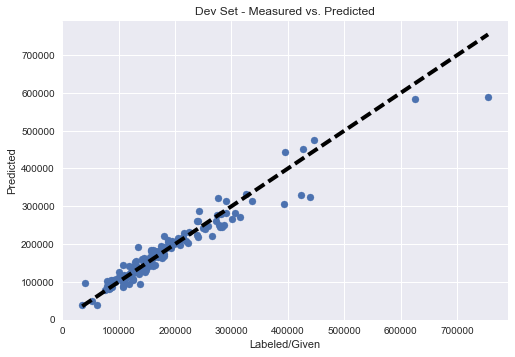

In [26]:
# plot the predicted vs actuals (similar to our original baseline model)
fig, ax = plt.subplots()
ax.scatter(actual, pred)
ax.plot([dev_labels.min(), dev_labels.max()], [dev_labels.min(), dev_labels.max()], 'k--', lw=4)
ax.set_xlabel('Labeled/Given')
ax.set_ylabel('Predicted')
plt.title("Dev Set (feature reduced and mulit-model) - Measured vs. Predicted")
plt.show()

Comparing to our baseline model (original chart from baseline file included again below as an image), the chart shows the most improvement at higher priced homes. 
Low and mid-tier homes has remained fairly consistent, however there is improvement in the clustering/bunching of observations along the line (as desired).


<img src="bslnchart.png">

### PICKLE IT!

In [ ]:
#pickle.dump(best_cat_models, open( "best_cat_models.p", "wb" ) )

## PROCESSING TEST DATA

Note, test data could have been transformed and categorized along with training and dev originally.
Team choose to separate the testing, and run at the end (keeping all of the testing processes together).
For our process, this required re-running the optimal models at the end.

In [22]:
# IMPORT and PROCESS TEST DATA

# import test data
test = pd.read_csv('data/test.csv')

# separate out Ids for submitting to Kaggle (similar to a label, but an idenitifier, vs price)
test_ids = test['Id']

# transform features
# follows transformation used for training and dev data
# note that is uses variables defined above and functions in the data_funcs.py file


# transforming features
test_data = test.set_index('Id')[keep_columns]
test_data = transform_features(test_data,feature_dict,normal_cat_features,used_cat_features,
                                likert_features,drop_dummies,drop_features)


# Mean normalizing
test_data = mean_normalization(test_data, features_to_normalize, mn_values)

# convert to np arrays
test_data = np.array(test_data)

# deal with NaNs (which won't work in regression)
where_are_NaNs = isnan(test_data)
test_data[where_are_NaNs] = 0

In [23]:
# APPLY CATEGORIZATION TO TEST DATA

# categorize test data using best models identified
t= [350000]         # cat threshold at 350,000
pca_comp = 10    # 10 pca components
smoothC = 10     # smoothing C at 10

# categorize using best models identified
train_cat_labels = list(categorize_prices(labels=train_labels, thresholds = t))
train_subset, test_subset, nonzero_features = run_logr_l1(train_data, train_cat_labels, test_data, final_features)
train_pca_subset, test_pca_subset = run_pca(train_subset, test_subset, components = pca_comp)
train_categories, test_categories = run_logr_l2(train_pca_subset, train_cat_labels,test_pca_subset, c=smoothC)


# run put 1421 test records under 350000 adn 38 above 350000 (in line with expectations)
# len(test_categories[test_categories==0])
# len(test_categories[test_categories==1])

## APPLY REGRESSION TO TEST DATA

In [24]:
# APPLY REGRESSION TO TEST DATA
testids = []
test_predictions = []

for category_num in [0,1]:
    model = best_cat_models[category_num]
    model_name = model[0]
    best_params = model[2].best_params_
    
    # reduce feature set
    pca = PCA(n_components=best_params['features__pca__n_components'])
        
    # Select high value original features
    selection = SelectKBest(k=best_params['features__univ_select__k'])
        
    combined_features = FeatureUnion([("pca", pca), ("univ_select", selection)])
        
    # Use combined features to transform dataset:
    sub_features = combined_features.fit(train_data, train_labels)
    train_reduced = sub_features.transform(train_data)
    test_reduced = sub_features.transform(test_data)

    
    # separate out category data (1421 and 38 for test data)
        
    #subset out specific category
    cat_train_data, cat_train_labels, cat_test_data, cat_test_ids = build_test_cats(category_num, train_reduced, test_reduced, 
                                                                      train_labels, test_ids, train_categories, test_categories)

    # refit 
    if model_name == 'lr':
        # initializing model with best parameters
        model = LinearRegression(fit_intercept = best_params['lr__fit_intercept'])

    elif model_name == 'rfr':
        model = RandomForestRegressor(n_estimators=best_params['rfr__n_estimators'], random_state=0, n_jobs=-1)
    
    
    model.fit(cat_train_data, cat_train_labels)
    predictions = model.predict(cat_test_data)
    predictions[predictions < 0] = 0 # hack for predictions less than zero
    testids.append(cat_test_ids)
    test_predictions.append(predictions)

# flatten list of lists
test_identifier = [val for sublist in testids for val in sublist]
final_predictions = [val for sublist in test_predictions for val in sublist]

In [25]:
# create csv to send to kaggle
with open('mm_predictions_1.csv', 'wb') as f:
    writer = csv.writer(f)
    writer.writerow(('Id', 'SalePrice'))
    writer.writerows(izip(test_identifier, final_predictions))